# Case Study: Using K-Means Clustering and Random Forest to Predict Chemotherapy Response
This notebook demonstrates how to:
1. Explore patient cancer data - note that the data has been cleaned and the values have been scaled.
2. Apply K-Means clustering to determine which patients may respond to chemotherapy
3. Use an elbow plot to determine the optimal number of clusters
4. Use Random Forest to predict cluster membership, turning the problem into supervised learning

In [35]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score



In [10]:
df = pd.read_csv('cancer_patient_data_scaled.csv')
df.head()

,age,tumor_size,biomarker_1,biomarker_2,gene_expr_1,gene_expr_2,inflammation_score,prior_treatments
0,-0.978806,-1.644280,0.945098,-1.230543,0.066790,-1.004709,0.874507,-0.173845
1,1.357198,-0.758122,-1.052323,1.196824,-1.060625,-0.378995,-0.075597,0.063437
2,-0.877276,-1.640922,0.621816,-0.878444,0.490924,-0.563728,-0.078360,-0.420844
3,-0.679601,-0.578410,0.623338,-0.910961,1.435954,0.055916,1.972682,1.027528
4,2.118638,-0.361899,-2.164821,1.249258,-0.450372,0.494442,0.815889,-0.557747


## Step 1: Explore the data

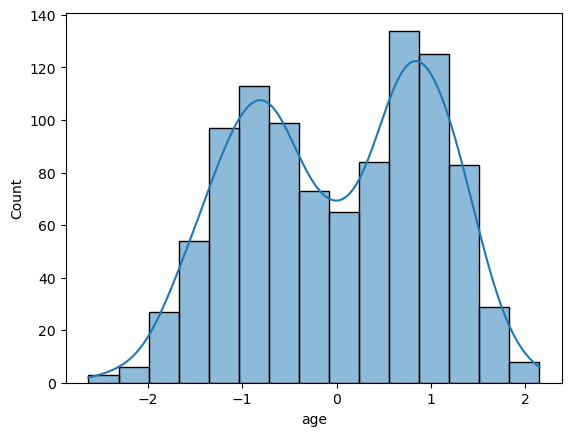

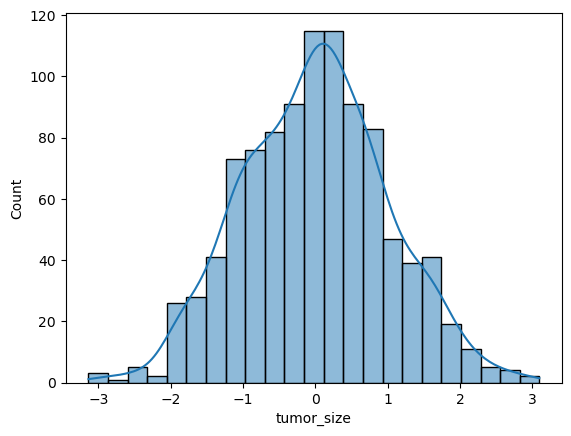

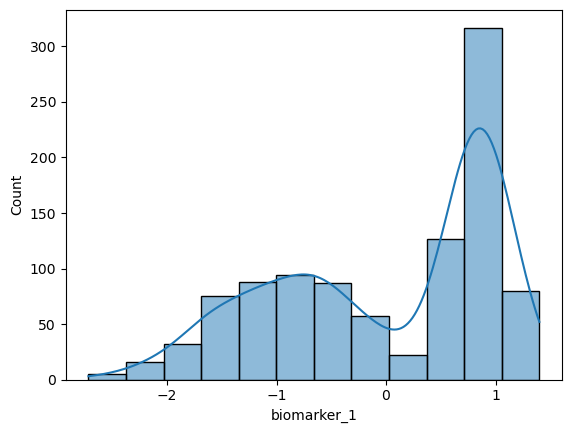

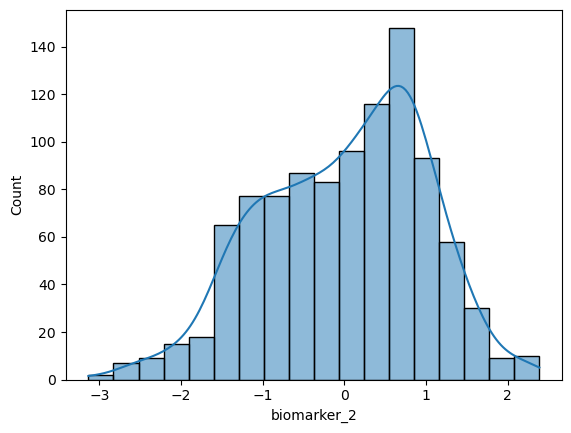

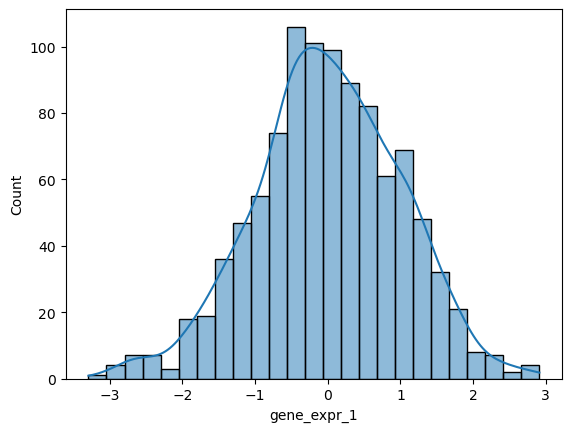

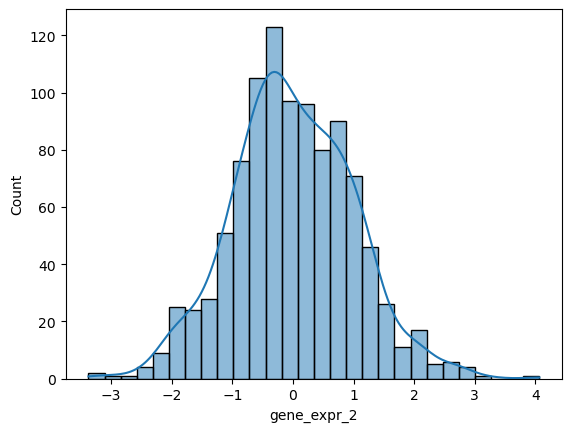

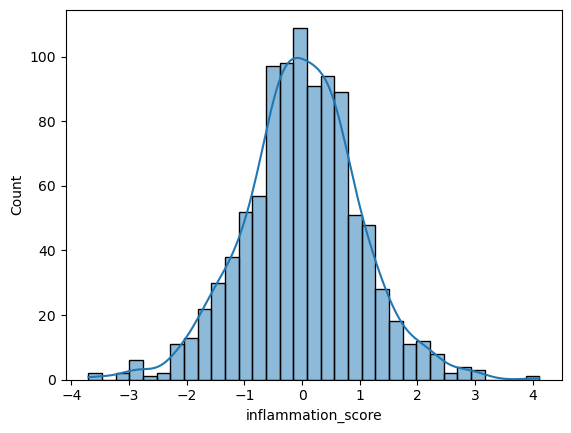

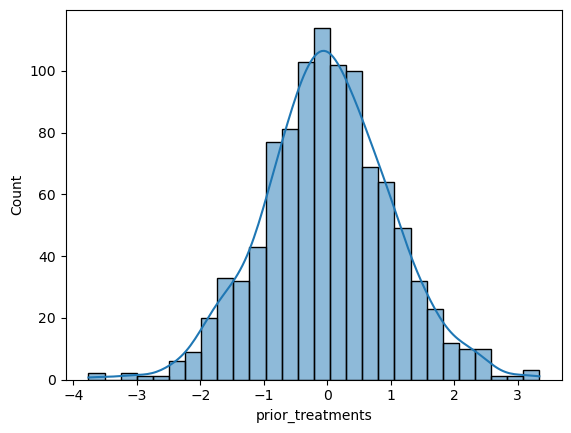

In [16]:
# Check distributions
for col in df.columns:
    sn.histplot(data=df, x=col, kde=True)
    plt.show()

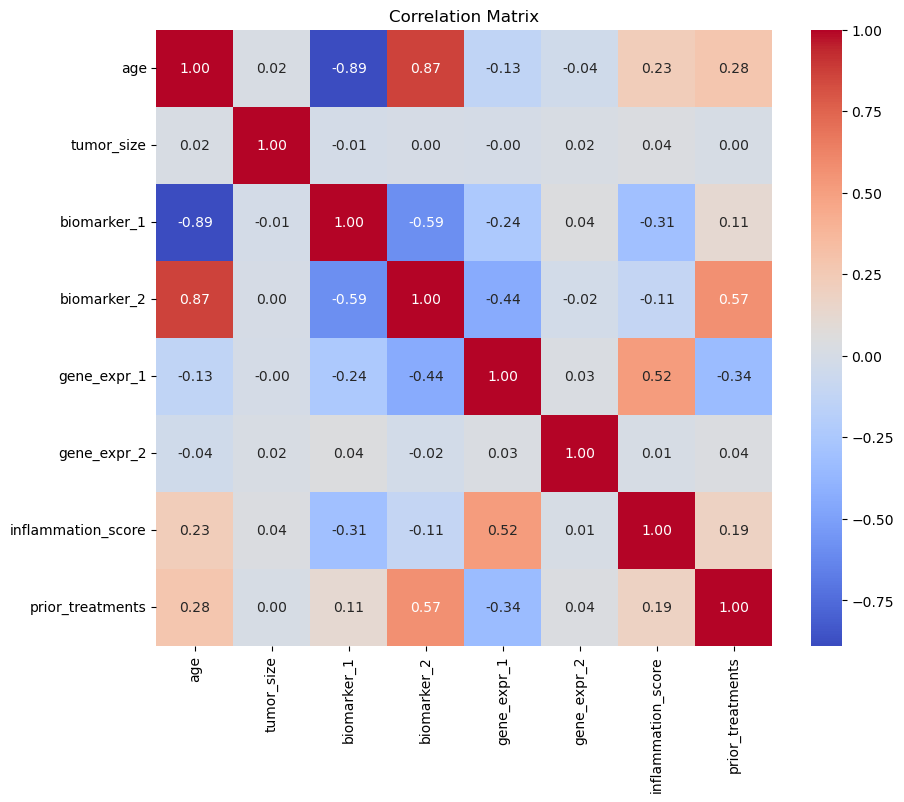

In [18]:
# Check for colinearity
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

In [19]:
# Check for columns with low variance
for col in df.columns:
    print(col, ': ', df[col].var())

age :  1.0010010010212627
tumor_size :  1.0010010009996388
biomarker_1 :  1.001001001012339
biomarker_2 :  1.0010010009778973
gene_expr_1 :  1.001001001009793
gene_expr_2 :  1.001001000986203
inflammation_score :  1.0010010010101555
prior_treatments :  1.0010010010032406


## Step 2: Elbow Method to Identify Optimal Number of Clusters

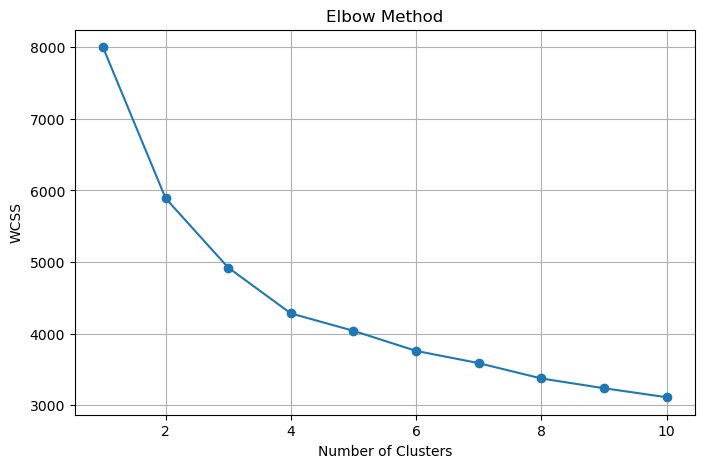

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## Step 3: Apply K-Means Clustering with 2 Clusters

In [23]:
# Apply KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df)
df['cluster'] = clusters
df.head()

,age,tumor_size,biomarker_1,biomarker_2,gene_expr_1,gene_expr_2,inflammation_score,prior_treatments,cluster
0,-0.978806,-1.644280,0.945098,-1.230543,0.066790,-1.004709,0.874507,-0.173845,1
1,1.357198,-0.758122,-1.052323,1.196824,-1.060625,-0.378995,-0.075597,0.063437,0
2,-0.877276,-1.640922,0.621816,-0.878444,0.490924,-0.563728,-0.078360,-0.420844,1
3,-0.679601,-0.578410,0.623338,-0.910961,1.435954,0.055916,1.972682,1.027528,1
4,2.118638,-0.361899,-2.164821,1.249258,-0.450372,0.494442,0.815889,-0.557747,0


## Step 4: Visualize Clusters using PCA

In [26]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

df_pca.head()

,PC1,PC2,cluster
0,1.668598,0.318032,1
1,-2.132045,-0.472260,0
2,1.508349,0.219818,1
3,0.912387,1.532989,1
4,-2.944481,1.091202,0


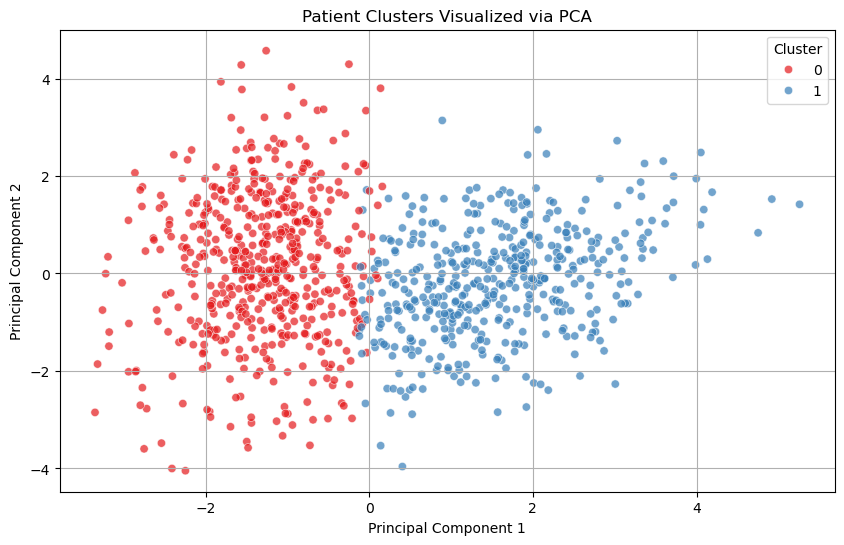

In [27]:
# Plot
plt.figure(figsize=(10, 6))
sn.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set1', alpha=0.7)
plt.title('Patient Clusters Visualized via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## Step 5: Use Random Forest to Predict Clusters

In [34]:


# Train-test split
X = df.drop('cluster', axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("AUC: ", roc_auc_score(y_test, y_pred))

Accuracy Score:  0.985
AUC:  0.9842595404393156


## Build Final Model

In [38]:
rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(rf, X, y, cv=skf, scoring='accuracy')

# Output the results
print("Fold Accuracies:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Fold Accuracies: [0.98 0.98 1.   0.98 0.99 1.   1.   0.98 1.   1.  ]
Mean Accuracy: 0.991
Standard Deviation: 0.009433981132056611
